<a href="https://colab.research.google.com/github/vev1574/sberbank_data_analysis_06_07_21/blob/master/hw_timeseries_vev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import datetime
import time
from pandas import Timestamp
import numpy as np
import calendar
from pandas.tseries.holiday import Holiday,AbstractHolidayCalendar
from pandas.tseries.offsets import MonthEnd, YearEnd, CustomBusinessDay

### Упражнение 1

* Скачайте с портала Открытых Данных производственный календарь России: https://data.gov.ru/opendata/7708660670-proizvcalendar
* На его основе определите соответствующий календарь в Pandas: `RussianBusinessCalendar(AbstractHolidayCalendar)`
* С помощью полученного в пункте выше календаря и модуля `pd.offsets` создайте DataFrame one-hot календарных признаков:
    * День недели
    * Месяц
    * Выходной день
    * Праздничный день
    * Предпраздничный рабочий день
    * Последний день месяца
    * Последний рабочий день месяца
    * Предновогодний выходной день

In [3]:
data = pd.read_csv('/content/drive/MyDrive/data-20191112T1252-structure-20191112T1247 (1).csv') 

In [4]:
data.head(5)

,Год/Месяц,Январь,Февраль,Март,Апрель,Май,Июнь,Июль,Август,Сентябрь,Октябрь,Ноябрь,Декабрь,Всего рабочих дней,Всего праздничных и выходных дней,Количество рабочих часов при 40-часовой рабочей неделе,Количество рабочих часов при 36-часовой рабочей неделе,Количество рабочих часов при 24-часовой рабочей неделе
0,1999,"1,2,3,4,6*,7,9,10,16,17,23,24,30,31","6,7,13,14,20,21,27,28","6,7,8,13,14,20,21,27,28","3,4,10,11,17,18,24,25,30*","1,2,3,4,8,9,10,15,16,22,23,29,30","5,6,11*,12,13,14,19,20,26,27","3,4,10,11,17,18,24,25,31","1,7,8,14,15,21,22,28,29","4,5,11,12,18,19,25,26","2,3,9,10,16,17,23,24,30,31","6,7,8,13,14,20,21,27,28","4,5,11,12,13,18,19,25,26,31*",251,114,2004,1807.2,1204.8
1,2000,"1,2,3,4,6*,7,8,9,15,16,22,23,29,30","5,6,12,13,19,20,26,27","4,5,7*,8,11,12,18,19,25,26","1,2,8,9,15,16,22,23,29,30","1,2,6,7,8*,9,13,14,20,21,27,28","3,4,10,11,12,17,18,24,25","1,2,8,9,15,16,22,23,29,30","5,6,12,13,19,20,26,27","2,3,9,10,16,17,23,24,30","1,7,8,14,15,21,22,28,29","4,5,7,11,12,18,19,25,26","2,3,9,10,11*,12,16,17,23,24,30,31",250,116,1995,1800.0,1200.0
2,2001,"1,2,6,7,8,13,14,20,21,27,28","3,4,10,11,17,18,24,25","3,4,7*,8,10,11,17,18,24,25,31","1,7,8,14,15,21,22,28,29,30*","1,2,5,6,8*,9,12,13,19,20,26,27","2,3,9,10,11*,12,16,17,23,24,30","1,7,8,14,15,21,22,28,29","4,5,11,12,18,19,25,26","1,2,8,9,15,16,22,23,29,30","6,7,13,14,20,21,27,28","3,4,6*,7,10,11,17,18,24,25","1,2,8,9,12,15,16,22,23,29,30",251,114,2001,1807.2,1204.8
3,2002,"1,2,5,6,7,12,13,19,20,26,27","2,3,9,10,16,17,22*,23,24,25","2,3,7*,8,9,10,16,17,23,24,30,31","6,7,13,14,20,21,28,30*","1,2,3,4,5,8*,9,10,11,12,19,25,26","1,2,8,9,11*,12,15,16,22,23,29,30","6,7,13,14,20,21,27,28","3,4,10,11,17,18,24,25,31","1,7,8,14,15,21,22,28,29","5,6,12,13,19,20,26,27","2,3,6*,7,8,9,16,17,23,24,30","1,7,8,11*,12,13,14,21,22,28,29,31*",250,115,1992,1792.0,1192.0
4,2003,"1,2,3,5*,6,7,11,12,18,19,25,26","1,2,8,9,15,16,22,23,24","1,2,7*,8,9,10,15,16,22,23,29,30","5,6,12,13,19,20,26,27,30*","1,2,3,4,8*,9,10,11,17,18,24,25,31","1,7,8,11*,12,13,14,15,22,28,29","5,6,12,13,19,20,26,27","2,3,9,10,16,17,23,24,30,31","6,7,13,14,20,21,27,28","4,5,11,12,18,19,25,26","1,2,6*,7,8,9,15,16,22,23,29,30","6,7,11*,12,13,14,20,21,27,28,31*",250,115,1992,1792.0,1192.0


In [5]:
X=pd.DataFrame()
X= pd.date_range('1999-1-1', periods=9862,name='Дата', freq='D',)
X[-1]

Timestamp('2025-12-31 00:00:00', freq='D')

In [6]:
events= pd.DataFrame(X).set_index('Дата')
events['выходной']=events['праздник']=events['предпразд']=events['посрабден']=events['посденмес']=events['посвыхгода']=0
mon=["Январь","Февраль","Март","Апрель","Май","Июнь","Июль","Август","Сентябрь","Октябрь","Ноябрь","Декабрь"]
dayw=["пн","вт","ср","чт","пт","сб","вс"]
celeb=['01-01-','07-01-','23-02-','08-03-','01-05-','12-06-','04-11-']
a=[]; b=[]; c=[]; ldy=[]
for y in range(0,27): 
  for i in celeb:
    c+=pd.to_datetime([i+str(data['Год/Месяц'][y])],dayfirst=True)
  for m in range(0,12):  
    for d in data.loc[y][str(mon[m])].split(','):
      try:
        d = d.replace('+', '')
        a+=pd.to_datetime([d+'-' + str(m+1)+'-' +str(data['Год/Месяц'][y])],dayfirst=True)#выходные без знаков вместе с перенесенными "+" 
      except ValueError:# звездочки*
         d = d.replace('*', '')
         b+=pd.to_datetime([d+'-' + str(m+1)+'-' +str(data['Год/Месяц'][y])],dayfirst=True)#предпраздничные
  ldy.append(a[-1])

events['выходной'].loc[a]=1
events['предпразд'].loc[b]=1
events['праздник'].loc[c]=1
hd=events[events['праздник']==1].index
my_bd = CustomBusinessDay(holidays=hd)
events['посрабден'].loc[(events.index+MonthEnd(0)-my_bd).unique()]=1
events['посденмес'].loc[(events.index+MonthEnd(0)).unique()]=1
events['посвыхгода'].loc[ldy]=1

for i in range(0,7):
  events[str(dayw[i])]=(X.weekday==i).astype(np.int8)
for i in range(0,12):
  events[str(mon[i])]=(X.month==i+1).astype(np.int8)

events.sample(10)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:694: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,


,выходной,праздник,предпразд,посрабден,посденмес,посвыхгода,пн,вт,ср,чт,пт,сб,вс,Январь,Февраль,Март,Апрель,Май,Июнь,Июль,Август,Сентябрь,Октябрь,Ноябрь,Декабрь
Дата,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-08,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2003-01-11,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2006-12-11,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2016-12-24,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2010-10-08,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2003-11-28,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2020-08-23,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2012-12-08,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2017-02-22,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [104]:
events[events['посрабден']==1].sample(5)

,выходной,праздник,предпразд,посрабден,посденмес,посвыхгода,пн,вт,ср,чт,пт,сб,вс,Январь,Февраль,Март,Апрель,Май,Июнь,Июль,Август,Сентябрь,Октябрь,Ноябрь,Декабрь
Дата,,,,,,,,,,,,,,,,,,,,,,,,,
2010-09-29,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2002-04-29,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2009-10-30,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2007-12-28,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2002-03-29,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


### Упражнение 2

* Для временного ряда курса акций Сбербанка на основе производственного календаря России сформируйте DataFrame признаков:
    * Лаговые переменные рабочих дней с глубинами: 1, 3, 5
    * Скользящие статистики `['mean', 'median', 'max', 'min', 'std'] ` с окнами 1, 3, 5 сгрупированные по дням недели
    * Статистики `['mean', 'median', 'max', 'min', 'std'] ` в расширяющемся окне сгруппированные по рабочим, праздничным и предпраздничным дням

In [29]:
ts = pd.read_csv('/content/drive/MyDrive/sber_stocks.csv', usecols=['CLOSE', 'TRADEDATE'], 
                 index_col='TRADEDATE', parse_dates=True)
ts = ts.CLOSE

In [30]:
tsd=ts.resample('1D').asfreq()

In [31]:
hg1=tsd.asfreq('1D').fillna(method='ffill').shift(1, freq=my_bd).head(5) 
hg2=tsd.asfreq('1D').fillna(method='ffill').shift(3, freq=my_bd).head(5)
hg3= tsd.asfreq('1D').fillna(method='ffill').shift(5, freq=my_bd).head(5)
hg1,hg2,hg3

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:694: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,


(TRADEDATE
 2013-03-26    98.79
 2013-03-27    97.20
 2013-03-28    96.75
 2013-03-29    98.59
 2013-04-01    98.76
 Name: CLOSE, dtype: float64, TRADEDATE
 2013-03-28    98.79
 2013-03-29    97.20
 2013-04-01    96.75
 2013-04-02    98.59
 2013-04-03    98.76
 Name: CLOSE, dtype: float64, TRADEDATE
 2013-04-01    98.79
 2013-04-02    97.20
 2013-04-03    96.75
 2013-04-04    98.59
 2013-04-05    98.76
 Name: CLOSE, dtype: float64)

In [103]:
median=[]
print('Скользящая. Группировка по дням недели.')
for i in range(1,6,2):
  print('Окно =',i,'\n', ts.rolling(window=i).mean().groupby(ts.index.weekday).describe(percentiles = median))

Скользящая. Группировка по дням недели.
Окно = 1 
            count        mean        std     min      50%     max
TRADEDATE                                                       
0          335.0  145.460716  62.585738   54.51  139.450  279.97
1          342.0  145.187135  62.201611   53.50  140.160  278.21
2          343.0  146.021662  62.164953   55.00  139.400  279.20
3          344.0  146.393837  62.047727   58.70  141.375  277.49
4          344.0  146.949942  61.965509   57.13  144.675  274.60
5            4.0  181.522500  55.146865  102.39  199.450  224.80
Окно = 3 
            count        mean        std         min         50%         max
TRADEDATE                                                                  
0          334.0  145.624062  62.561742   55.260000  138.888333  278.886667
1          341.0  145.143500  62.040534   55.513333  139.113333  278.556667
2          343.0  145.756638  61.948556   55.866667  139.073333  276.860000
3          344.0  146.266860  62.00400

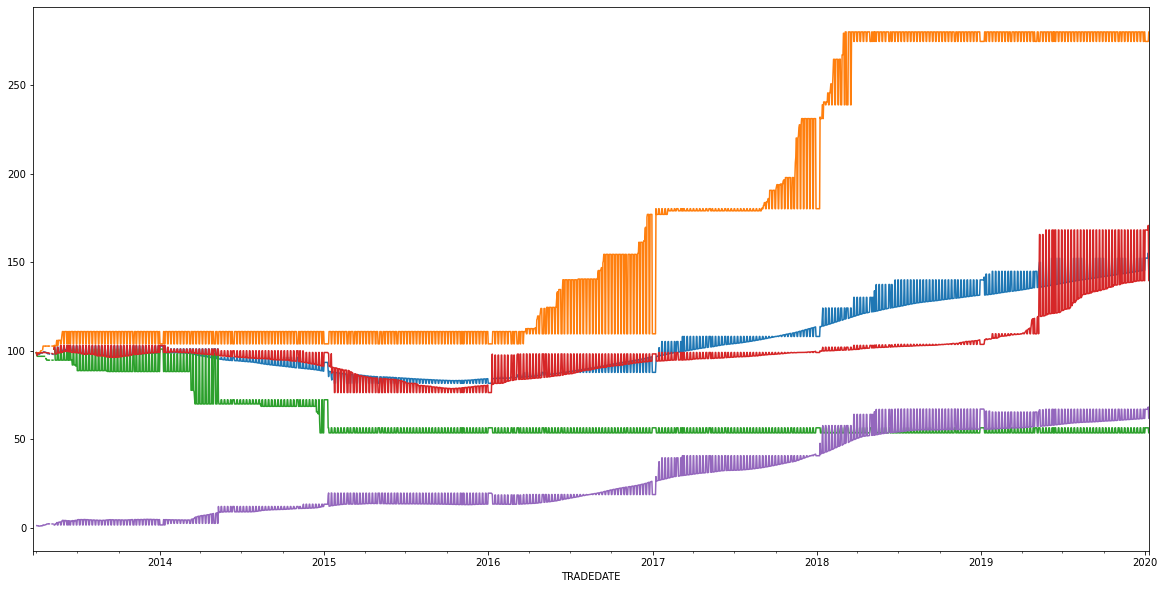

In [98]:
tsd.groupby(~events['выходной']).transform(lambda x: x.expanding().mean().shift(5)).plot(figsize=(20, 10))
tsd.groupby(~events['выходной']).transform(lambda x: x.expanding().max().shift(5)).plot(figsize=(20, 10))
tsd.groupby(~events['выходной']).transform(lambda x: x.expanding().min().shift(5)).plot(figsize=(20, 10))
tsd.groupby(~events['выходной']).transform(lambda x: x.expanding().median().shift(5)).plot(figsize=(20, 10))
tsd.groupby(~events['выходной']).transform(lambda x: x.expanding().std().shift(5)).plot(figsize=(20, 10))

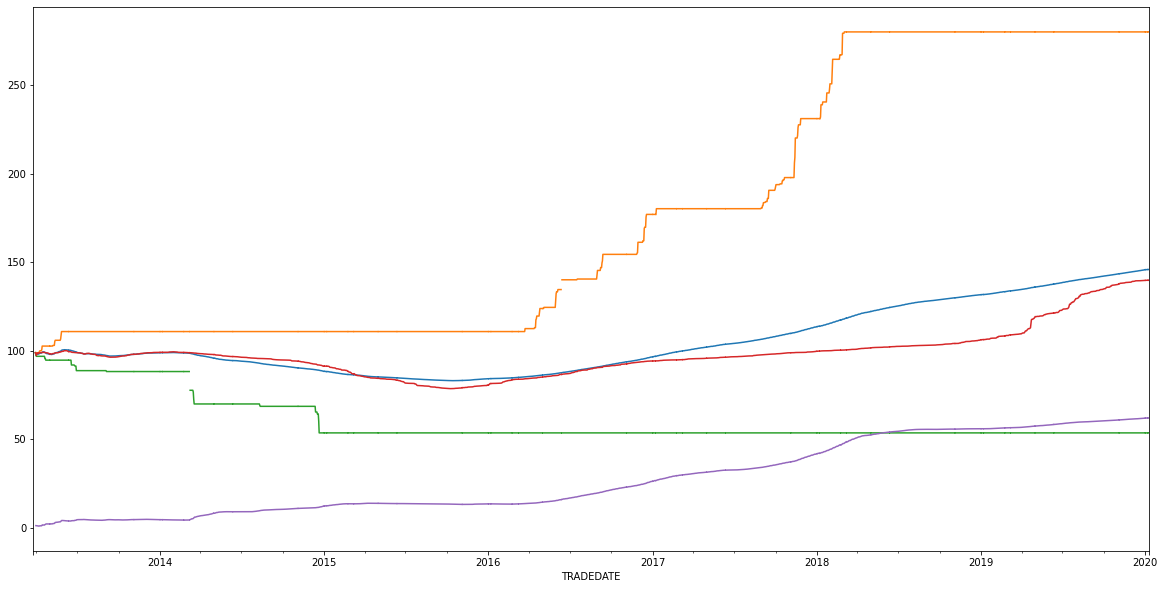

In [99]:
tsd.groupby(events['праздник']).transform(lambda x: x.expanding().mean().shift(5)).plot(figsize=(20, 10))
tsd.groupby(events['праздник']).transform(lambda x: x.expanding().max().shift(5)).plot(figsize=(20, 10))
tsd.groupby(events['праздник']).transform(lambda x: x.expanding().min().shift(5)).plot(figsize=(20, 10))
tsd.groupby(events['праздник']).transform(lambda x: x.expanding().median().shift(5)).plot(figsize=(20, 10))
tsd.groupby(events['праздник']).transform(lambda x: x.expanding().std().shift(5)).plot(figsize=(20, 10))

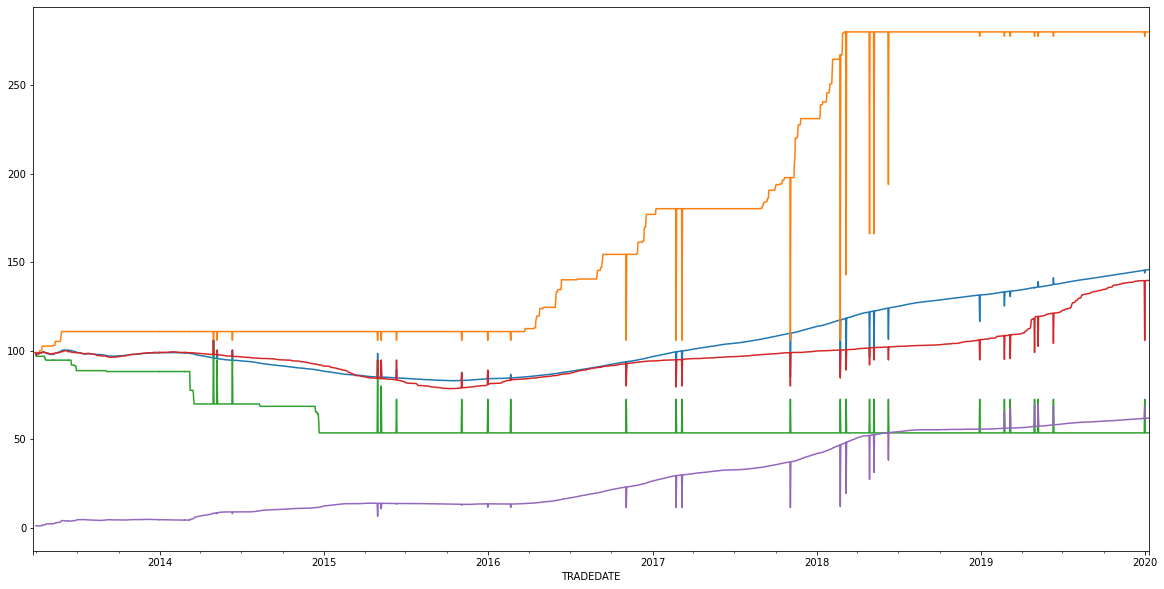

In [100]:
tsd.groupby(events['предпразд']).transform(lambda x: x.expanding().mean().shift(5)).plot(figsize=(20, 10))
tsd.groupby(events['предпразд']).transform(lambda x: x.expanding().max().shift(5)).plot(figsize=(20, 10))
tsd.groupby(events['предпразд']).transform(lambda x: x.expanding().min().shift(5)).plot(figsize=(20, 10))
tsd.groupby(events['предпразд']).transform(lambda x: x.expanding().median().shift(5)).plot(figsize=(20, 10))
tsd.groupby(events['предпразд']).transform(lambda x: x.expanding().std().shift(5)).plot(figsize=(20, 10))